# Image recognition of Anderson states

## Preliminaries

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
import torch
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.7.0'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.8.1+cu101
1.7.0+cu101


In [34]:
import random

In [35]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [36]:
#bs = 64
bs = 16  # uncomment this line if you run out of memory even after clicking Kernel->Restart
myepoch0 = 4
myepoch1 = 2
myepoch2 = 2
training_fraction = 0.6
validation_fraction = 0.1

## Reading in the image data

In [37]:
from google.colab import files

In [38]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay].append(float(line))
        #print(float(line))
        col += 1
    return system
        

In [ ]:
import os

data   = []
labels = []

datasrc = '/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs' #Source of the locations of the data

disorder_systems      = []
disorder_class_labels = []

for disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...
    print(disorder_class_folder.path)
    disorder_class = disorder_class_folder.path.rsplit('_',1)[1];
    print(disorder_class)
    disorder_systems.append([])
    disorder_class_labels.append(disorder_class)
    
    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...
        #print(file)                                             #...
        the_file = open(file.path, 'r')                          #...open the file to read the locations of the data...
        
        number_of_data = 0
        for line in the_file:                                    #...for each... 
            
            if (number_of_data < 1):                           #...gather a certain amount of data...
                print(" ")
                number_of_data += 1

                #print(line)
                line = line.rsplit('\n',1)[0]
                raw_data = open(line,'r')
                system = make_3D_structure(raw_data, 20)
                #print(system)
                disorder_systems[-1].append(system)
                print("added system to " + disorder_class_labels[-1])
     


In [39]:
class ThreeDDataset(Dataset):
    def __init__(self, x):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        self.c = len(self.x)

        t = True
        for dis_class in self.x:
          t = t and len(dis_class)==0
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]
        

In [48]:
#Data from the path
#np.random.seed(1234567)
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        #ds_tfms=get_transforms(do_flip=False,max_rotate=0.,max_warp=0.,max_zoom=1.0,max_lighting=None), 
                                  #size=256, num_workers=4).normalize(imagenet_stats)
        
N = 100    #Number of sample 3D systems
tensors_training = []  #Each list in this list is a seperate label list
tensors_validation = []  #Each list in this list is a seperate label list
tensors_testing = []  #Each list in this list is a seperate label list
n_labels = 10
#labels = []
for i in range(n_labels):
  tensors_training.append([])
  tensors_validation.append([])
  tensors_testing.append([])
for i in range(N):
  ten = torch.rand(4,4,4)
  #print(ten)

  c_label = random.randint(0,n_labels-1)
  #print(c_label)

  ran_numb = random.random()

  if ran_numb >= 1 - training_fraction:
    tensors_training[c_label].append(ten)
  
  if ran_numb < validation_fraction:
    tensors_validation[c_label].append(ten)
  
  else:
    tensors_testing[c_label].append(ten)

loader_training = ThreeDDataset(tensors_training)
loader_validation = ThreeDDataset(tensors_validation)
loader_testing = ThreeDDataset(tensors_testing)

databunch = DataBunch.create(loader_training, loader_validation, loader_testing, bs=2, num_workers=1)

## Train model

In [49]:
learn = cnn_learner(databunch, models.resnet50, metrics=error_rate, pretrained=False)#.to_fp16()

In [ ]:
learn.model

In [51]:
print(learn.summary())

RuntimeError: ignored

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


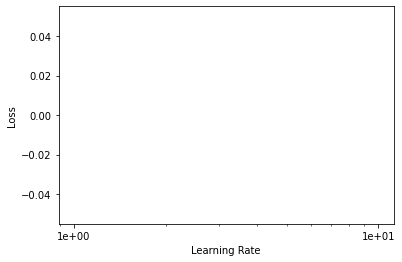

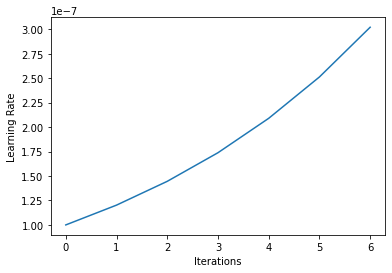

In [26]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

In [27]:
lr=1.e-2

In [29]:
learn.fit_one_cycle(myepoch0,lr)

epoch,train_loss,valid_loss,error_rate,time
0,-0.442021,0.584820,1.000000,00:17
1,-0.320930,-1.141303,0.909091,00:17
2,-0.917775,-1.841619,0.909091,00:17
3,-1.622899,-2.190560,0.909091,00:18


In [ ]:
learn.save('stage-0')

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

## Heatmap

In [ ]:
idx=0
x,y = loader.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## refining the model - stage 1

In [ ]:
learn.load('stage-0');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
#learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(myepoch1, max_lr=slice(3e-6,3e-4))

In [ ]:
learn.save('stage-1')

## refining the model further - stage 2

In [ ]:
learn.load('stage-1');
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(myepoch2, max_lr=slice(3e-6,1e-5))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-0');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))